# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 04.11.2022

Мягкий дедлайн: 23:59MSK 16.11.2022

Жесткий дедлайн: 23:59MSK 23.11.2022

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [4]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [ ]:
# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [6]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

AUC-PR: 0.63340
AUC-ROC: 0.50394


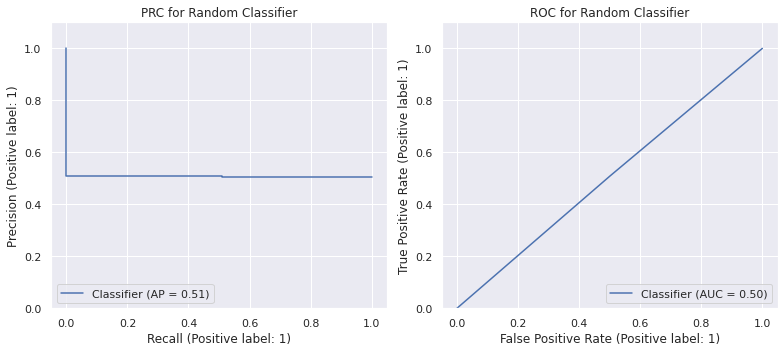

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_random))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [ ]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_random),
    None
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__

In [7]:
from sklearn.svm import SVC
from tqdm.notebook import tqdm

In [ ]:
X_train , X_val , y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
best_c = None
best_auc = -123

for c in np.linspace(1e-10, 3, 20):
  clf = SVC(kernel='linear', C=c).fit(X_train, y_train)
  y_pred = clf.predict(X_val)
  precision, recall, _ = precision_recall_curve(y_val, y_pred)
  cur_auc = auc(recall, precision)
  print(f'auc for c={c} is {cur_auc}')
  if cur_auc > best_auc:
    best_c = c
    best_auc = cur_auc

auc for c=1e-10 is 0.7464999999999999
auc for c=0.1578947369368421 is 0.8264540435069783
auc for c=0.3157894737736842 is 0.8268186828716789
auc for c=0.47368421061052635 is 0.8264540435069783
auc for c=0.6315789474473684 is 0.8264540435069783
auc for c=0.7894736842842105 is 0.8264540435069783
auc for c=0.9473684211210527 is 0.8264540435069783
auc for c=1.1052631579578946 is 0.8264540435069783
auc for c=1.2631578947947368 is 0.8264540435069783
auc for c=1.421052631631579 is 0.8264540435069783
auc for c=1.578947368468421 is 0.8264540435069783
auc for c=1.7368421053052632 is 0.8264540435069783
auc for c=1.8947368421421054 is 0.8264540435069783
auc for c=2.0526315789789473 is 0.8264540435069783
auc for c=2.2105263158157893 is 0.8264540435069783
auc for c=2.3684210526526317 is 0.8264540435069783
auc for c=2.5263157894894737 is 0.8264540435069783
auc for c=2.6842105263263156 is 0.8264540435069783
auc for c=2.842105263163158 is 0.8264540435069783
auc for c=3.0 is 0.8264540435069783


In [ ]:
best_c, best_auc

(0.3157894737736842, 0.8268186828716789)

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

AUC-PR: 0.83390
AUC-ROC: 0.77545


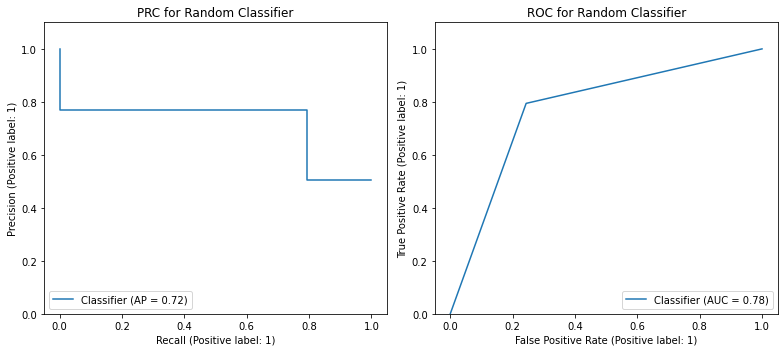

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

clf = SVC(kernel='linear', C=best_c).fit(X_train, y_train)
y_pred = clf.predict(X_test)

PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_pred))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

best_c_logreg = None
best_auc = -123

for c in np.linspace(1e-10, 3, 20):
  clf = LogisticRegression(C=c).fit(X_train, y_train)
  y_pred = clf.predict(X_val)
  precision, recall, _ = precision_recall_curve(y_val, y_pred)
  cur_auc = auc(recall, precision)
  print(f'auc for C={c} is {cur_auc}')
  if cur_auc > best_auc:
    best_c_logreg = c
    best_auc = cur_auc

auc for C=1e-10 is 0.7464999999999999
auc for C=0.1578947369368421 is 0.8275687162735844
auc for C=0.3157894737736842 is 0.8275687162735844
auc for C=0.47368421061052635 is 0.8275687162735844
auc for C=0.6315789474473684 is 0.8275687162735844
auc for C=0.7894736842842105 is 0.8275687162735844
auc for C=0.9473684211210527 is 0.8275687162735844
auc for C=1.1052631579578946 is 0.8275687162735844
auc for C=1.2631578947947368 is 0.8275687162735844
auc for C=1.421052631631579 is 0.8275687162735844
auc for C=1.578947368468421 is 0.8275687162735844
auc for C=1.7368421053052632 is 0.8275687162735844
auc for C=1.8947368421421054 is 0.8275687162735844
auc for C=2.0526315789789473 is 0.8275687162735844
auc for C=2.2105263158157893 is 0.8275687162735844
auc for C=2.3684210526526317 is 0.8275687162735844
auc for C=2.5263157894894737 is 0.8275687162735844
auc for C=2.6842105263263156 is 0.8275687162735844
auc for C=2.842105263163158 is 0.8275687162735844
auc for C=3.0 is 0.8275687162735844


In [ ]:
best_c_logreg, best_auc

(0.3157894737736842, 0.8275687162735844)

AUC-PR: 0.83299
AUC-ROC: 0.77396


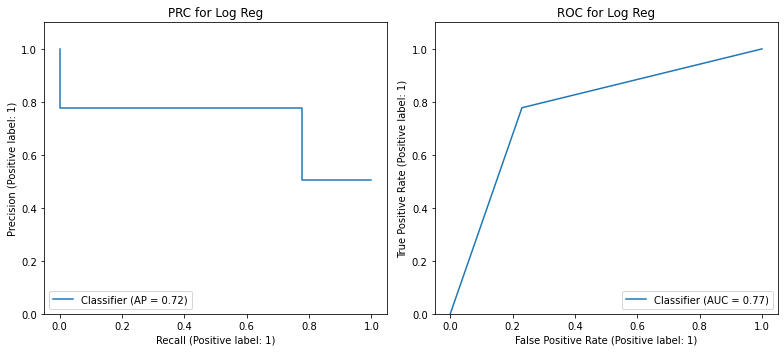

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

clf = LogisticRegression(C=best_c_logreg).fit(X_train, y_train)
y_pred = clf.predict(X_test)

PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Log Reg")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_pred))
ax[1].set_title("ROC for Log Reg")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  Ответ: Различий в PR и AUC практически нет, у SVM чуть выше.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). 

In [ ]:
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = SVC(kernel='linear', C=best_c).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


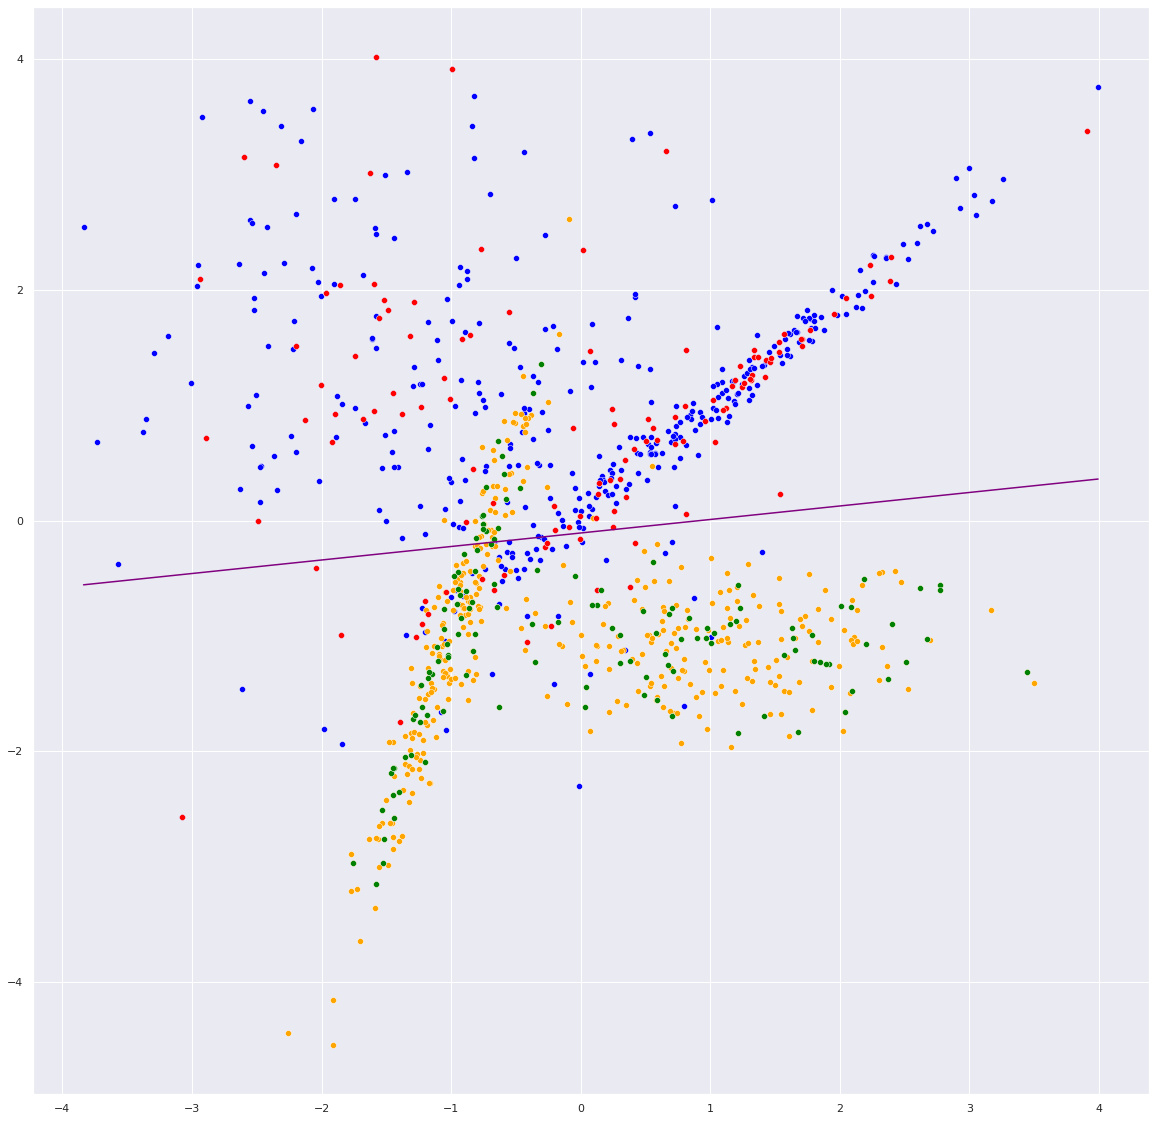

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 20)})
sns.set_style('darkgrid')

sns.scatterplot(x=X[y == 1][:, 0], y=X[y == 1][:, 1], color='blue')
sns.scatterplot(x=X[y == 0][:, 0], y=X[y == 0][:, 1], color='orange')

sns.scatterplot(x=X[np.intersect1d(clf.support_, (y == 1).nonzero())][:, 0], y=X[np.intersect1d(clf.support_, (y == 1).nonzero())][:, 1], color='red')
sns.scatterplot(x=X[np.intersect1d(clf.support_, (y == 0).nonzero())][:, 0], y=X[np.intersect1d(clf.support_, (y == 0).nonzero())][:, 1], color='green')

w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
yy = a * xx - (clf.intercept_[0]) / w[1]

sns.lineplot(xx, yy, color='purple')

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

In [ ]:
clf = LogisticRegression(C=best_c_logreg).fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)

[(-5.0, 5.0), Text(0, 0.5, '$X_2$'), (-5.0, 5.0), Text(0.5, 0, '$X_1$'), None]

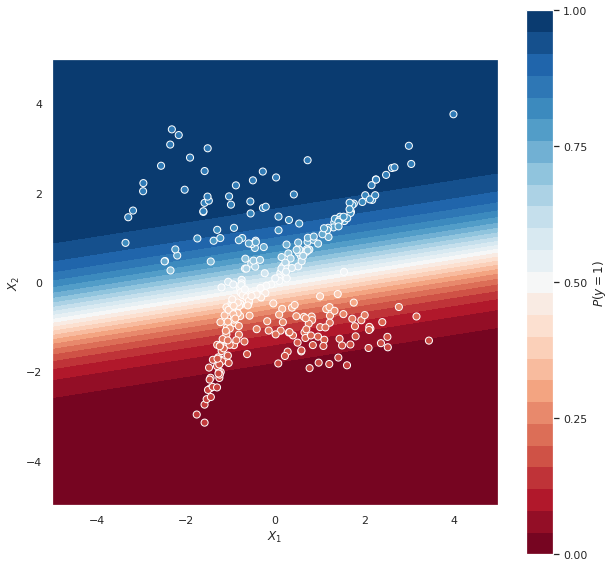

In [ ]:
# https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression

xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(10, 10))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)

ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_test[:,0], X_test[:, 1], c=y_pred[:, 1], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$")

#### __Задание 2. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        part = y_test[(preds[:, 1] >= l) & (preds[:, 1] <= r)]
        bin_real_ratios.append(np.sum(part) / part.shape[0])
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
    plt.ylim([-0.05, 1.05])
    plt.grid()

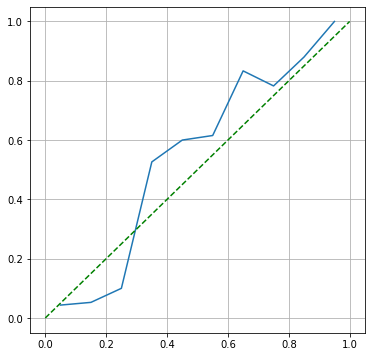

In [ ]:
plot_calibration_curve(y_test, y_pred)

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

In [ ]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
best_c = 0.3157894737736842
best_c_logreg = 0.3157894737736842

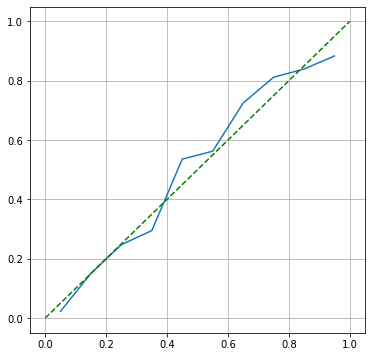

In [ ]:
svc_clf = SVC(kernel='linear', C=best_c, probability=True).fit(X_train, y_train)
plot_calibration_curve(y_test, svc_clf.predict_proba(X_test))
svc_pred = svc_clf.decision_function(X_test)

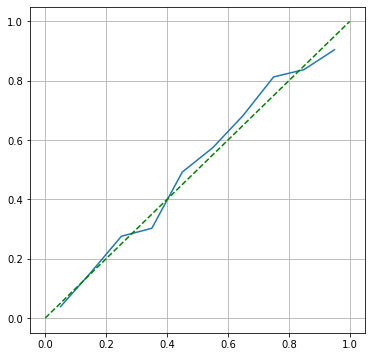

In [ ]:
lr_clf = LogisticRegression(C=best_c_logreg).fit(X_train, y_train)
plot_calibration_curve(y_test, lr_clf.predict_proba(X_test))
lr_pred = lr_clf.decision_function(X_test)

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

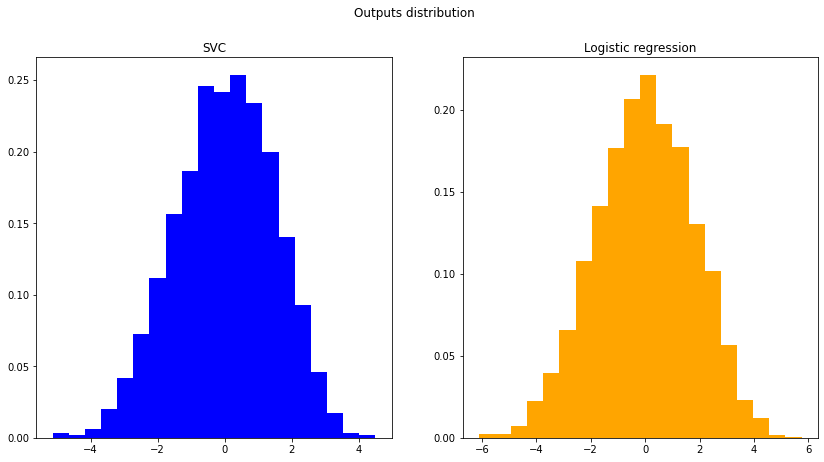

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()


Чем они различаются? Чем вы можете объяснить это?

Ответ: SVC опти

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [ ]:
svc_clf = SVC(kernel='linear', C=best_c, probability=True).fit(X_train, y_train)
svc_pred = svc_clf.predict_proba(X_test)[:, 1]
svc_clf = SVC(kernel='linear', C=best_c, probability=True)
sigmoid_svc = CalibratedClassifierCV(svc_clf, cv=10, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

SVC ROC-AUC: 0.8477693357057863


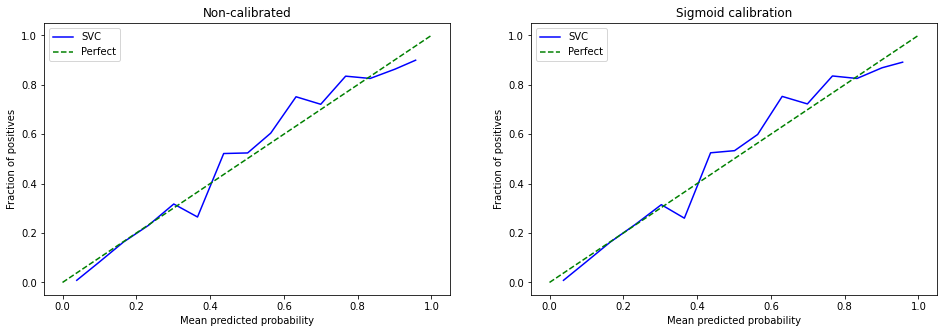

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=15)

axs[0].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[0].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[0].set_title('Non-calibrated')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, sigmoid_svc_pred, n_bins=15)

axs[1].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[1].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[1].set_title('Sigmoid calibration')

for ax in axs:
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Fraction of positives')
    ax.legend()

plt.show()

Кривая практически не изменилась, но стоит отметить, что она изначально бвыла близка к диагональной

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла. 

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет. 

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2022-11-22 15:18:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  7.26MB/s    in 0.5s    

2022-11-22 15:18:26 (7.26 MB/s) - ‘adult.data’ saved [3974305/3974305]



In [10]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [11]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df, df['income'], test_size=1/3, random_state=777, stratify=df['income'])

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegressionCV
import time

In [ ]:
categorical = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]

numeric_features = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

column_transformer = ColumnTransformer([
    ('ohe', OrdinalEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('log-reg', LogisticRegression(max_iter=10000, C=1, random_state=777))
])

t = time.process_time()
model = pipeline.fit(X_train, y_train)
elapsed_time = time.process_time() - t
print('Time for train and encoding:', elapsed_time)

Time for train and encoding: 2.131614957


AUC-PR: 0.64060


(0.0, 1.1)

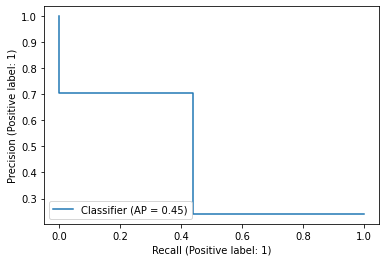

In [ ]:
y_pred = model.predict(X_test)
PrecisionRecallDisplay.from_predictions(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax.set_title("PRC for Log Reg")
ax.set_ylim(0, 1.1)

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__: потому что AUC-ROC не зависит от выбранного порога, а в данном случае нам более интересен класс людей, который зарабатывают больше 50К в год, поэтому AUC-PR более показателен.

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
categorical = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]

numeric_features = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('log-reg', LogisticRegression(max_iter=10000, C=1, random_state=777))
])

t = time.process_time()
model = pipeline.fit(X_train, y_train)
elapsed_time = time.process_time() - t
print('Time for train and encoding:', elapsed_time)

Time for train and encoding: 0.8295733299999988


AUC-PR: 0.70900


(0.0, 1.1)

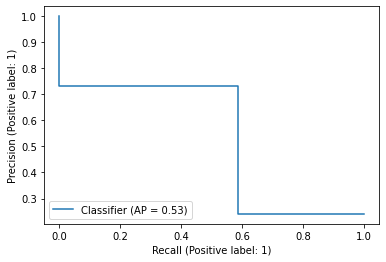

In [ ]:
y_pred = model.predict(X_test)
PrecisionRecallDisplay.from_predictions(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax.set_title("PRC for Log Reg")
ax.set_ylim(0, 1.1)

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
    
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        pass
    
    def fit(self, X=None, y=None):
        self.X_train = X.copy()
        self.X_train['income'] = y
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in self.columns:
          X_copy[col] = X_copy[col].map(self.X_train.groupby(col)['income'].mean())
        return X_copy

In [ ]:
column_transformer = ColumnTransformer([
    ('mean-target-encoder', MeanTargetEncoder(categorical), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('log-reg', LogisticRegression(max_iter=10000, C=1, random_state=777))
])

t = time.process_time()
model = pipeline.fit(X_train, y_train)
elapsed_time = time.process_time() - t
print('Time for train and encoding:', elapsed_time)

Time for train and encoding: 0.5601180429999957


странно но время кодирования упало

AUC-PR: 0.70080


(0.0, 1.1)

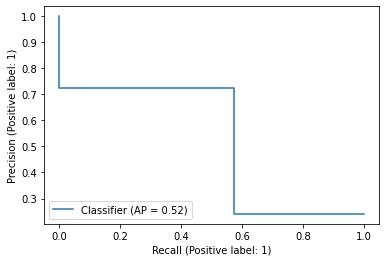

In [ ]:
y_pred = model.predict(X_test)
PrecisionRecallDisplay.from_predictions(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax.set_title("PRC for Log Reg")
ax.set_ylim(0, 1.1)

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

**В предыдущем пункте уже сделал это, map не векторизованный, но он идет по числу значений не зависящему от размера выборки (у категориальных признаков немного значений), так что данная реализация является эффективной**

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
    
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        pass
    
    def fit(self, X=None, y=None):
        self.X_train = X.copy()
        self.X_train['income'] = y
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in self.columns:
          X_copy[col] = X_copy[col].map(self.X_train.groupby(col)['income'].mean())
          X_copy[col] += np.random.normal(0, 0.1, X_copy.shape[0])
          X_copy[col].clip(0, 1, inplace=True)
        return X_copy

In [ ]:
column_transformer = ColumnTransformer([
    ('mean-target-encoder', MeanTargetEncoder(categorical), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('log-reg', LogisticRegression(max_iter=10000, C=1, random_state=777))
])

t = time.process_time()
model = pipeline.fit(X_train, y_train)
elapsed_time = time.process_time() - t
print('Time for train and encoding:', elapsed_time)

Time for train and encoding: 0.5228961440000006


AUC-PR: 0.68882


(0.0, 1.1)

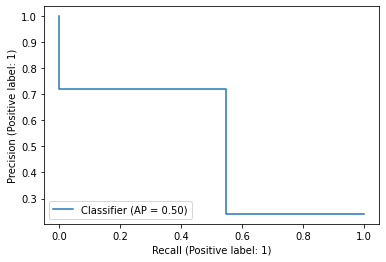

In [ ]:
y_pred = model.predict(X_test)
PrecisionRecallDisplay.from_predictions(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax.set_title("PRC for Log Reg")
ax.set_ylim(0, 1.1)

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты.


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
    
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns, noise=True):
        self.columns = columns
        self.noise = noise
        pass
    
    def fit(self, X=None, y=None):
        self.X_train = X.copy()
        self.X_train['income'] = y
        self.global_mean = y.mean()
        return self

    def smooth_mean(self, income):
        C = 10
        return (income.sum() + C * self.global_mean) / (income.shape[0] + C)

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in self.columns:
          X_copy[col] = X_copy[col].map(self.X_train.groupby(col)['income'].agg(self.smooth_mean)).fillna(self.global_mean)
          if self.noise:
            X_copy[col] += np.random.normal(0, 0.1, X_copy.shape[0])
            X_copy[col].clip(0, 1, inplace=True)
        return X_copy

In [ ]:
categorical = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]

numeric_features = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

column_transformer = ColumnTransformer([
    ('mean-target-encoder', MeanTargetEncoder(categorical, noise=False), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('log-reg', LogisticRegression(max_iter=10000, C=0.1, random_state=777))
])

t = time.process_time()
model = pipeline.fit(X_train, y_train)
elapsed_time = time.process_time() - t
print('Time for train and encoding:', elapsed_time)

Time for train and encoding: 0.5127174570000079


AUC-PR: 0.69929


(0.0, 1.1)

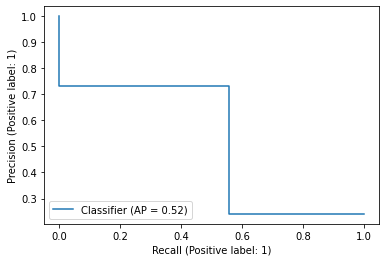

In [ ]:
y_pred = model.predict(X_test)
PrecisionRecallDisplay.from_predictions(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax.set_title("PRC for Log Reg")
ax.set_ylim(0, 1.1)

#### __Задание 8. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



Time for train and encoding: 0.5405644109999912
AUC-PR: 0.70835


(0.0, 1.1)

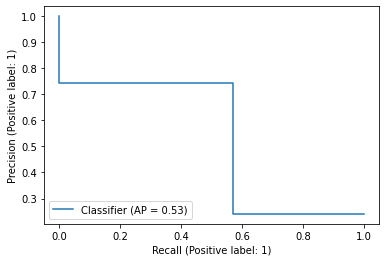

In [ ]:
categorical = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
    "age"
]

numeric_features = [
    # "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

column_transformer = ColumnTransformer([
    ('mean-target-encoder', MeanTargetEncoder(categorical, noise=False), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('log-reg', LogisticRegression(max_iter=10000, C=0.1, random_state=777))
])

t = time.process_time()
model = pipeline.fit(X_train, y_train)
elapsed_time = time.process_time() - t
print('Time for train and encoding:', elapsed_time)

y_pred = model.predict(X_test)
PrecisionRecallDisplay.from_predictions(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax.set_title("PRC for Log Reg")
ax.set_ylim(0, 1.1)

Time for train and encoding: 0.4944667249999952
AUC-PR: 0.70670


(0.0, 1.1)

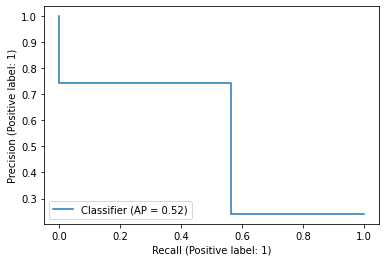

In [ ]:
categorical = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
    "age",
    "hours-per-week"
]

numeric_features = [
    # "age",
    "education-num",
    "capital-gain",
    "capital-loss"
    # "hours-per-week",
]

column_transformer = ColumnTransformer([
    ('mean-target-encoder', MeanTargetEncoder(categorical, noise=False), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('log-reg', LogisticRegression(max_iter=10000, C=0.1, random_state=777))
])

t = time.process_time()
model = pipeline.fit(X_train, y_train)
elapsed_time = time.process_time() - t
print('Time for train and encoding:', elapsed_time)

y_pred = model.predict(X_test)
PrecisionRecallDisplay.from_predictions(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax.set_title("PRC for Log Reg")
ax.set_ylim(0, 1.1)

Time for train and encoding: 0.5626085549999971
AUC-PR: 0.69967


(0.0, 1.1)

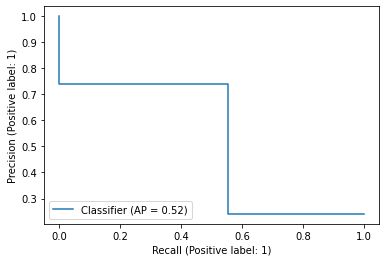

In [ ]:
categorical = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
    "hours-per-week"
]

numeric_features = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss"
    # "hours-per-week",
]

column_transformer = ColumnTransformer([
    ('mean-target-encoder', MeanTargetEncoder(categorical, noise=False), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('log-reg', LogisticRegression(max_iter=10000, C=0.1, random_state=777))
])

t = time.process_time()
model = pipeline.fit(X_train, y_train)
elapsed_time = time.process_time() - t
print('Time for train and encoding:', elapsed_time)

y_pred = model.predict(X_test)
PrecisionRecallDisplay.from_predictions(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax.set_title("PRC for Log Reg")
ax.set_ylim(0, 1.1)

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ таргет-кодирование только возраста дало лучший результат. Ксли кодировать часы (и отдельно и вместе с возрастом), то качество чуть выше чем если считать их числовыми, но хуже чем при таргет-кодировании только возраста

# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2022-11-23 12:33:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... failed: Connection timed out.
Retrying.

--2022-11-23 12:35:30--  (try: 2)  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
^C


In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df['income'], test_size=1/3, random_state=777, stratify=df['income'])

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegressionCV
import time

In [ ]:
categorical = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]

numeric_features = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

column_transformer.fit(X_train)

print("Feature quantity before OneHot:", X_train.shape[1])
print("Feature quantity after OneHot:", column_transformer.transform(X_train).shape[1])

Feature quantity before OneHot: 15
Feature quantity after OneHot: 107


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.set_style('darkgrid')

categorical = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]

numeric_features = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('log-reg', LogisticRegression(max_iter=10000, C=0.1, random_state=777))
])

t = time.process_time()
model = pipeline.fit(X_train, y_train)
elapsed_time = time.process_time() - t
print('Time for train and encoding:', elapsed_time)

y_pred = model.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

Time for train and encoding: 0.5100082519999987
AUC-PR: 0.70898


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
feature_names = np.append(model.named_steps['ohe_and_scaling'].transformers_[0][1].get_feature_names_out(), model.named_steps['ohe_and_scaling'].transformers_[1][1].get_feature_names_out().reshape(-1, 1))

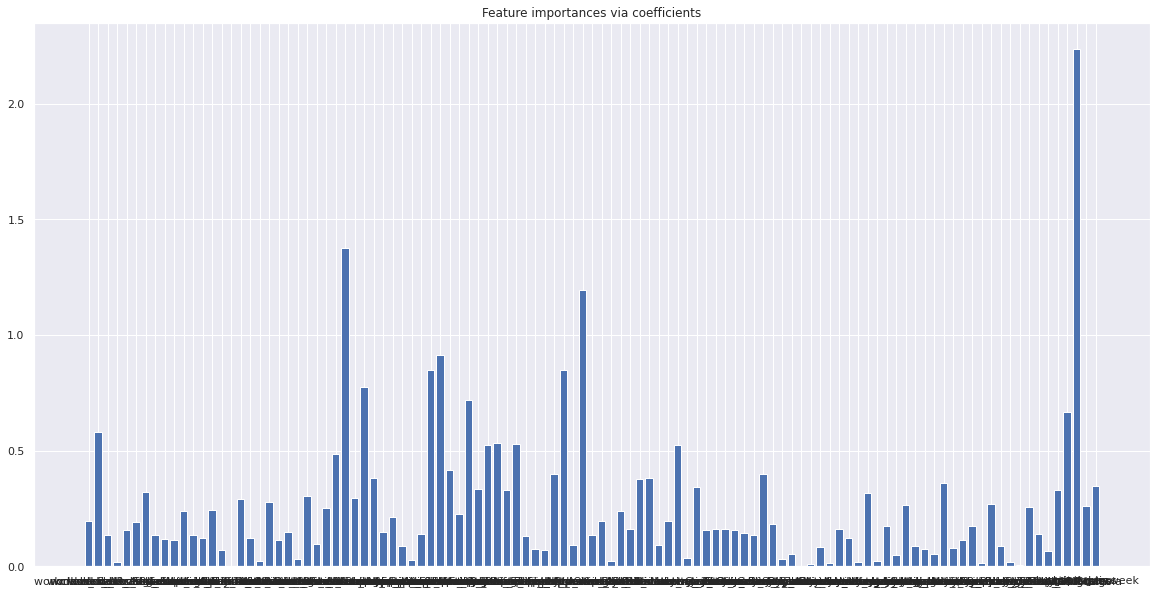

In [ ]:
importance = np.abs(model.named_steps['log-reg'].coef_)[0]
f, ax = plt.subplots(figsize=(20, 10))
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel

threshold = np.sort(importance)[-40]
selector = SelectFromModel(model.named_steps['log-reg'], threshold=threshold).fit(column_transformer.transform(X_train), y_train)
print("Отобранные признаки:\n", '\n'.join(feature_names[selector.get_support()]))

Отобранные признаки:
 workclass_ Federal-gov
workclass_ Self-emp-not-inc
education_ 5th-6th
education_ Assoc-acdm
education_ Doctorate
education_ Prof-school
marital-status_ Divorced
marital-status_ Married-AF-spouse
marital-status_ Married-civ-spouse
marital-status_ Married-spouse-absent
marital-status_ Never-married
marital-status_ Separated
occupation_ Exec-managerial
occupation_ Farming-fishing
occupation_ Handlers-cleaners
occupation_ Other-service
occupation_ Priv-house-serv
occupation_ Prof-specialty
occupation_ Protective-serv
occupation_ Sales
occupation_ Tech-support
relationship_ Other-relative
relationship_ Own-child
relationship_ Wife
race_ Other
sex_ Female
sex_ Male
native-country_ Canada
native-country_ Columbia
native-country_ Germany
native-country_ Italy
native-country_ Mexico
native-country_ Philippines
native-country_ South
native-country_ United-States
age
education-num
capital-gain
capital-loss
hours-per-week


Time for train and encoding: 0.8244503660000007
AUC-PR: 0.70963


(0.0, 1.1)

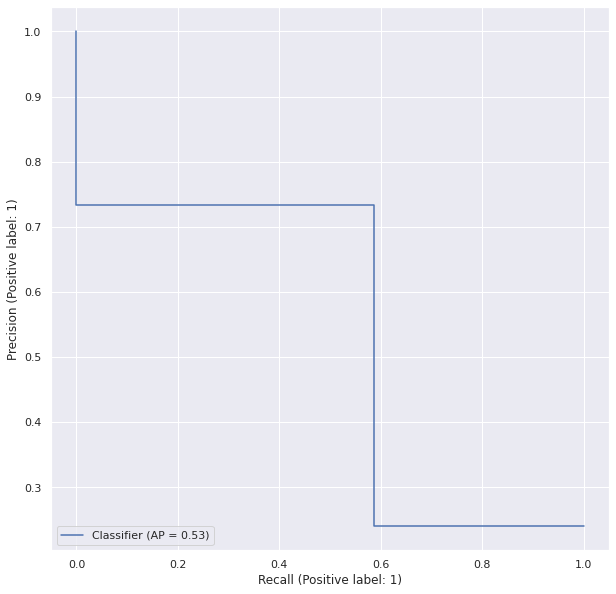

In [ ]:
categorical = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]

numeric_features = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('feature-selection', selector),
    ('log-reg', LogisticRegression(max_iter=10000, C=0.1, random_state=777))
])

t = time.process_time()
model = pipeline.fit(X_train, y_train)
elapsed_time = time.process_time() - t
print('Time for train and encoding:', elapsed_time)

y_pred = model.predict(X_test)
PrecisionRecallDisplay.from_predictions(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax.set_title("PRC for Log Reg")
ax.set_ylim(0, 1.1)

Изменилось ли качество? Как?

Качество стало выше на одну сотую

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
# обучим без масштабирования данных

categorical = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]

numeric_features = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    # ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('log-reg', LogisticRegression(max_iter=10000, C=0.1, random_state=777))
])

model = pipeline.fit(X_train, y_train)

y_pred = model.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.66318


In [ ]:
importance = np.abs(model.named_steps['log-reg'].coef_)[0]
threshold = np.sort(importance)[-40]
selector = SelectFromModel(model.named_steps['log-reg'], threshold=threshold).fit(column_transformer.transform(X_train), y_train)

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    # ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('feature-selection', selector),
    ('log-reg', LogisticRegression(max_iter=10000, C=0.1, random_state=777))
])

model = pipeline.fit(X_train, y_train)

y_pred = model.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.66031


Получили, что при отборе признаков по их вкладу и при этом не масштабируя данные мы ухудшем качество модели, а если перед этим масштабировать, тот качество возрастает (плюс облегчается модель)

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
feature_names = np.append(model.named_steps['ohe_and_scaling'].transformers_[0][1].get_feature_names_out(), numeric_features)

In [ ]:
categorical = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]

numeric_features = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

trans_X_train = column_transformer.fit_transform(X_train)
trans_X_train = pd.DataFrame(trans_X_train.toarray())

trans_X_test = column_transformer.transform(X_test)
trans_X_test = pd.DataFrame(trans_X_test.toarray())

scaler = StandardScaler()
trans_X_train = scaler.fit_transform(trans_X_train)
trans_X_train = pd.DataFrame(trans_X_train)

trans_X_test = scaler.transform(trans_X_test)
trans_X_test = pd.DataFrame(trans_X_test)

model = LogisticRegression(max_iter=10000, C=0.1, random_state=777)
model.fit(trans_X_train, y_train)

y_pred = model.predict(trans_X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.70949


In [ ]:
importance = np.abs(model.coef_)[0]
threshold = np.sort(importance)[-40]
selector = SelectFromModel(model, threshold=threshold).fit(column_transformer.transform(X_train), y_train)

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('feature-selection', selector),
    ('log-reg', LogisticRegression(max_iter=10000, C=0.1, random_state=777))
])

trans_X_train = column_transformer.fit_transform(X_train)
trans_X_train = pd.DataFrame(trans_X_train.toarray())
trans_X_train = selector.transform(trans_X_train)

trans_X_test = column_transformer.transform(X_test)
trans_X_test = pd.DataFrame(trans_X_test.toarray())
trans_X_test = selector.transform(trans_X_test)

scaler = StandardScaler()
trans_X_train = scaler.fit_transform(trans_X_train)
trans_X_train = pd.DataFrame(trans_X_train)

trans_X_test = scaler.transform(trans_X_test)
trans_X_test = pd.DataFrame(trans_X_test)

model = LogisticRegression(max_iter=10000, C=0.1, random_state=777)
model.fit(trans_X_train, y_train)

y_pred = model.predict(trans_X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.70932


Качество практически не изменилось

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [ ]:
def pr_auc(estimator, X, y):
  y_pred = estimator.predict_proba(X_test)[:, 1]
  precision, recall, _ = precision_recall_curve(y_test, y_pred)
  return auc(recall, precision)

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('log_reg', LogisticRegression(max_iter=10000))
])

# до этого не делал CV, но переделывать времени нет, очевидно, что результаты были бы гораздо лучше в предыдущих пунктах
clf = GridSearchCV(estimator=pipeline,
            param_grid={'log_reg__C': np.logspace(-1, 1, 5)},
            scoring=pr_auc,
            cv=5)

clf.fit(X_train, y_train)
print('AUC-PR: %.5f' % pr_auc(clf, X_test, y_test))
print(clf.best_params_)

AUC-PR: 0.76210
{'log_reg__C': 0.1}


In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

trans_X_train = column_transformer.fit_transform(X_train)
trans_X_train = pd.DataFrame(trans_X_train.toarray())

In [ ]:
pos_class = (y_train.values == 1)
pos_q, neg_q = np.sum(pos_class), np.sum(~pos_class)
means_diff = np.abs(np.mean(trans_X_train[pos_class], axis=0) - np.mean(trans_X_train[~pos_class], axis=0))

pos_nsig = pos_q * np.std(trans_X_train[pos_class], axis=0)**2
neg_nsig = neg_q * np.std(trans_X_train[~pos_class], axis=0)**2

t = means_diff / np.sqrt((pos_nsig + neg_nsig) / (pos_q + neg_q))

threshold = sorted(t)[-40]

selector = SelectFromModel(clf.best_estimator_['log_reg'], threshold=threshold).fit(column_transformer.transform(X_train), y_train)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('feature-selection', selector),
    ('log_reg', LogisticRegression(max_iter=10000))
])

clf = GridSearchCV(estimator=pipeline,
                  param_grid={'log_reg__C': np.logspace(-1, 1, 5)},
                  scoring=pr_auc,
                  cv=5)

clf.fit(X_train, y_train)
print('AUC-PR: %.5f' % pr_auc(clf, X_test, y_test))
print(clf.best_params_)

AUC-PR: 0.76281
{'log_reg__C': 0.31622776601683794}


Качество немного выросло

#### __Задание 11. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('log_reg', LogisticRegression(max_iter=10000))
])

# до этого не делал CV, но переделывать времени нет, очевидно, что результаты были бы гораздо лучше в предыдущих пунктах
clf = GridSearchCV(estimator=pipeline,
            param_grid={'log_reg__C': np.logspace(-1, 1, 5)},
            scoring=pr_auc,
            cv=5)

clf.fit(X_train, y_train)
print('AUC-PR: %.5f' % pr_auc(clf, X_test, y_test))
print(clf.best_params_)

AUC-PR: 0.76210
{'log_reg__C': 0.1}


In [15]:
def pr_auc(estimator, X, y):
    try:
        probs = estimator.predict_proba(X)[:, 1]
    except:
        probs = estimator.decision_function(X)
        probs = (probs - np.min(probs)) / (np.max(probs) - np.min(probs))
    precision, recall, _ = precision_recall_curve(y, probs)
    return auc(recall, precision)

In [19]:
categorical = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]

numeric_features = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

def wrap_method():
  trans_X_train = pd.DataFrame(column_transformer.fit_transform(X_train).copy().toarray())
  trans_X_test = pd.DataFrame(column_transformer.transform(X_test).copy().toarray())
  feature_count = trans_X_train.shape[1]
  cut_size = trans_X_train.shape[0] // 8

  X_tr, X_val, y_tr, y_val = train_test_split(trans_X_train[:cut_size], y_train[:cut_size], test_size=0.2, random_state=777, stratify=y_train[:cut_size])
  chosen_features = np.ones(feature_count)
  for j in tqdm(range(1, feature_count - 40 + 1)):
      best_pr_auc = 0
      best_features = chosen_features
      for i in range(X_tr.shape[1]):
          if not chosen_features[i]:
              continue
          chosen_features[i] = 0
          features_mask = (chosen_features == 1)
          model = LogisticRegression(max_iter=10000)
          clf = model.fit(X_tr.loc[:, features_mask], y_tr)
          pr_auc_ = pr_auc(clf, X_val.loc[:, features_mask], y_val)
          if best_pr_auc <= pr_auc_:
              best_features = chosen_features.copy()
              best_pr_auc = pr_auc_
          chosen_features[i] = 1
      chosen_features = best_features.copy()
      print(f'for {feature_count - j} params AUC-PR: %.5f' % best_pr_auc)

  model = LogisticRegression(max_iter=10000)
  clf = model.fit(trans_X_train.loc[:, (chosen_features == 1)], y_train)
  print(f'ON TEST AUC-PR: %.5f' % pr_auc(model, trans_X_test.loc[:, (chosen_features == 1)], y_test))

wrap_method()

  0%|          | 0/67 [00:00<?, ?it/s]

for 106 params AUC-PR: 0.77444
for 105 params AUC-PR: 0.78097
for 104 params AUC-PR: 0.78609
for 103 params AUC-PR: 0.78805
for 102 params AUC-PR: 0.78956
for 101 params AUC-PR: 0.79349
for 100 params AUC-PR: 0.79497
for 99 params AUC-PR: 0.79623
for 98 params AUC-PR: 0.79661
for 97 params AUC-PR: 0.79779
for 96 params AUC-PR: 0.79863
for 95 params AUC-PR: 0.79954
for 94 params AUC-PR: 0.80013
for 93 params AUC-PR: 0.80068
for 92 params AUC-PR: 0.80123
for 91 params AUC-PR: 0.80175
for 90 params AUC-PR: 0.80225
for 89 params AUC-PR: 0.80307
for 88 params AUC-PR: 0.80333
for 87 params AUC-PR: 0.80351
for 86 params AUC-PR: 0.80369
for 85 params AUC-PR: 0.80373
for 84 params AUC-PR: 0.80373
for 83 params AUC-PR: 0.80373
for 82 params AUC-PR: 0.80373
for 81 params AUC-PR: 0.80373
for 80 params AUC-PR: 0.80373
for 79 params AUC-PR: 0.80373
for 78 params AUC-PR: 0.80373
for 77 params AUC-PR: 0.80373
for 76 params AUC-PR: 0.80373
for 75 params AUC-PR: 0.80373
for 74 params AUC-PR: 0.80373
for

Уменьшил размер выборки, так как слишком долго ждать было бы. Качество улучшить не удалось

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [25]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

def backward_wrap_method():
    trans_X_train = pd.DataFrame(column_transformer.fit_transform(X_train).copy().toarray())
    trans_X_test = pd.DataFrame(column_transformer.transform(X_test).copy().toarray())
    feature_count = trans_X_train.shape[1]
    cut_size = trans_X_train.shape[0] // 2

    X_tr, X_val, y_tr, y_val = train_test_split(trans_X_train[:cut_size], y_train[:cut_size], test_size=0.2, random_state=777, stratify=y_train[:cut_size])
    chosen_features = np.zeros(feature_count)
    for j in tqdm(range(1, 41)):
        best_pr_auc = 0
        best_features = chosen_features
        for i in range(X_tr.shape[1]):
            if chosen_features[i]:
                continue
            chosen_features[i] = 1
            features_mask = (chosen_features == 1)
            model = LogisticRegression(max_iter=10000)
            clf = model.fit(X_tr.loc[:, features_mask], y_tr)
            pr_auc_ = pr_auc(clf, X_val.loc[:, features_mask], y_val)
            if best_pr_auc <= pr_auc_:
                best_features = chosen_features.copy()
                best_pr_auc = pr_auc_
            chosen_features[i] = 0
        chosen_features = best_features.copy()
        print(f'for {j} params AUC-PR: %.5f' % best_pr_auc)

    model = LogisticRegression(max_iter=10000)
    clf = model.fit(trans_X_train.loc[:, (chosen_features == 1)], y_train)
    print(f'ON TEST AUC-PR: %.5f' % pr_auc(model, trans_X_test.loc[:, (chosen_features == 1)], y_test))
    return chosen_features

chosen_features = backward_wrap_method()

  0%|          | 0/40 [00:00<?, ?it/s]

for 1 params AUC-PR: 0.67032
for 2 params AUC-PR: 0.67641
for 3 params AUC-PR: 0.73576
for 4 params AUC-PR: 0.75263
for 5 params AUC-PR: 0.75839
for 6 params AUC-PR: 0.76386
for 7 params AUC-PR: 0.76985
for 8 params AUC-PR: 0.77244
for 9 params AUC-PR: 0.77432
for 10 params AUC-PR: 0.77533
for 11 params AUC-PR: 0.77655
for 12 params AUC-PR: 0.77805
for 13 params AUC-PR: 0.77904
for 14 params AUC-PR: 0.77995
for 15 params AUC-PR: 0.78103
for 16 params AUC-PR: 0.78171
for 17 params AUC-PR: 0.78224
for 18 params AUC-PR: 0.78272
for 19 params AUC-PR: 0.78314
for 20 params AUC-PR: 0.78367
for 21 params AUC-PR: 0.78410
for 22 params AUC-PR: 0.78457
for 23 params AUC-PR: 0.78517
for 24 params AUC-PR: 0.78565
for 25 params AUC-PR: 0.78603
for 26 params AUC-PR: 0.78636
for 27 params AUC-PR: 0.78664
for 28 params AUC-PR: 0.78688
for 29 params AUC-PR: 0.78709
for 30 params AUC-PR: 0.78722
for 31 params AUC-PR: 0.78739
for 32 params AUC-PR: 0.78751
for 33 params AUC-PR: 0.78765
for 34 params AUC-P

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ: второй метод занял меньше времени (так как обучал меньшие модели) и позволил получить лучшие результаты. Но они все равно оказались ниже чем при использовании t-статистики, так как не делалась кросс-валидация (это было бы мега долго, а дедлайн близко)**

# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: 
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [27]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [28]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [43]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [45]:
from sklearn.model_selection import KFold, cross_val_score

categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('log_reg', LogisticRegression(max_iter=10000))
])

cross_val_score(pipeline, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=500))

array([0.90361738, 0.89973294, 0.89694101, 0.90749059, 0.89085832])

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [68]:
trans_X = column_transformer.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=500)
folds_predicts = np.empty(y.shape[0])
model = LogisticRegression(max_iter=10000)
for train_index, test_index in kf.split(trans_X):
    model.fit(trans_X[train_index], y[train_index])
    folds_predicts[test_index] = model.predict(trans_X[test_index])

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете? 
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [69]:
earnings = []
expenses = []

for train_index, test_index in kf.split(X):
    expenses.append(folds_predicts[test_index].sum())
    earnings.append(10 * y[test_index][folds_predicts[test_index] == 1].sum())

print(earnings, expenses)
earnings = np.array(earnings)
expenses = np.array(expenses)
print("В среднем заработаем:", np.mean(earnings))
print("Стандартное отклонение заработка:", np.std(earnings))
print("В среднем придется отдать работникам:", np.mean(expenses))
print("В среднем выручка:", np.mean(earnings - expenses))
print("Стандартное отклонение выручки:", np.std(earnings - expenses))

[2240, 2110, 2090, 2250, 1950] [310.0, 330.0, 330.0, 330.0, 320.0]
В среднем заработаем: 2128.0
Стандартное отклонение заработка: 110.34491379306978
В среднем придется отдать работникам: 324.0
В среднем выручка: 1804.0
Стандартное отклонение выручки: 111.46299834474219


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [94]:
earnings = []
expenses = []

for train_index, test_index in kf.split(X):
    expenses.append(folds_predicts[test_index].sum())
    payed_clients = y[test_index][folds_predicts[test_index] == 1]
    earnings.append((np.random.uniform(20, size=payed_clients.shape[0]) * payed_clients).sum())

print(earnings, expenses)
earnings = np.array(earnings)
expenses = np.array(expenses)
print("В среднем заработаем:", np.mean(earnings))
print("Стандартное отклонение заработка:", np.std(earnings))
print("В среднем придется отдать работникам:", np.mean(expenses))
print("В среднем выручка:", np.mean(earnings - expenses))
print("Стандартное отклонение выручки:", np.std(earnings - expenses))

[2332.1732265172486, 2263.2769704965467, 2207.0521584040534, 2427.2220190756657, 2050.257540882408] [310.0, 330.0, 330.0, 330.0, 320.0]
В среднем заработаем: 2255.996383075185
Стандартное отклонение заработка: 126.41055744616301
В среднем придется отдать работникам: 324.0
В среднем выручка: 1931.9963830751847
Стандартное отклонение выручки: 125.81767925301709


Получили что хоть ожидаемая выручка выросла, но ее стандартное отклонение составляет практически 50% от ее величины

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [97]:
trans_X = column_transformer.fit_transform(X)

def C_search(verbose=True):
    kf = KFold(n_splits=5, shuffle=True, random_state=500)
    best_c = 0
    best_metric = -1e6
    Cs = []
    revs = []
    stds = []
    for C in np.logspace(-1, 1, 5):
        expenses, earnings = [], []
        for train_index, test_index in kf.split(X):
            model = LogisticRegression(max_iter=10000)
            model.fit(trans_X[train_index], y[train_index])
            fold_predicts = model.predict(trans_X[test_index])
            expenses.append(fold_predicts.sum())
            payed_clients = y[test_index][fold_predicts == 1]
            earnings.append((np.random.uniform(20, size=payed_clients.shape[0]) * payed_clients).sum())
        earnings = np.array(earnings)
        expenses = np.array(expenses)
        revenue = earnings - expenses
        revenue_metric = revenue.mean()
        if revenue_metric > best_metric:
            best_metric = revenue_metric
            best_c = C
        if verbose:
            print(f"При C={C} в среднем выручка:", np.mean(revenue))
            print(f"При C={C} cтандартное отклонение выручки:", np.std(revenue))

        Cs.append(C)
        revs.append(revenue_metric)
        stds.append(np.std(revenue))

    plt.figure(figsize=(10, 7))
    plt.errorbar(Cs, revs, stds)
    plt.xscale('log')
    plt.show()
    print(f"best_c={best_c}, best_metric={best_metric}")
    return best_c, best_metric

При C=0.1 в среднем выручка: 1910.1315373029702
При C=0.1 cтандартное отклонение выручки: 119.26291001826019
При C=0.31622776601683794 в среднем выручка: 1910.2121115008972
При C=0.31622776601683794 cтандартное отклонение выручки: 149.79539240779968
При C=1.0 в среднем выручка: 1926.81292912462
При C=1.0 cтандартное отклонение выручки: 144.40851316054832
При C=3.1622776601683795 в среднем выручка: 1934.368033143756
При C=3.1622776601683795 cтандартное отклонение выручки: 126.49433766789835
При C=10.0 в среднем выручка: 1850.5244514364454
При C=10.0 cтандартное отклонение выручки: 137.1692437937927


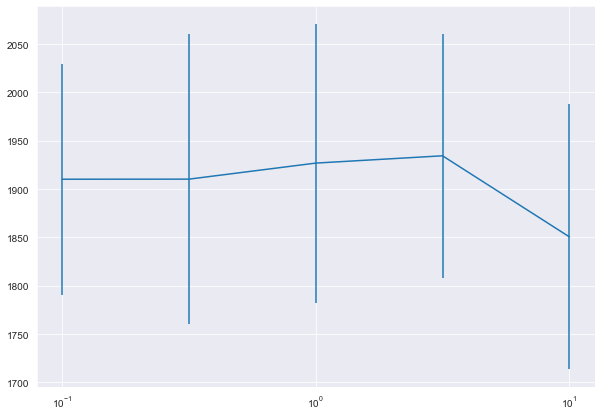

best_c=3.1622776601683795, best_metric=1934.368033143756


(3.1622776601683795, 1934.368033143756)

In [98]:
C_search()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

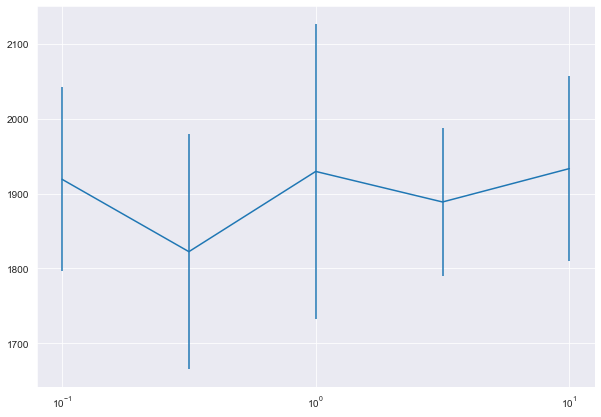

best_c=10.0, best_metric=1933.2482863135833


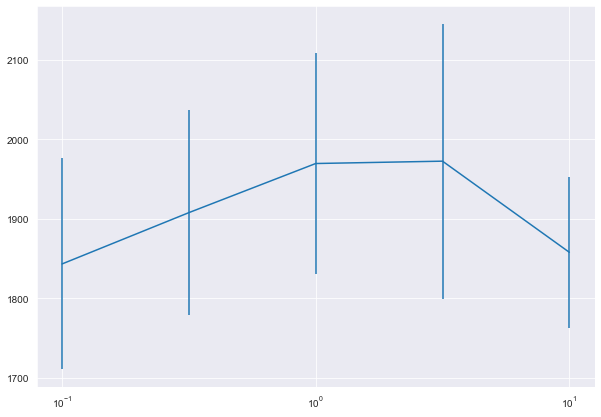

best_c=3.1622776601683795, best_metric=1972.3016294168538


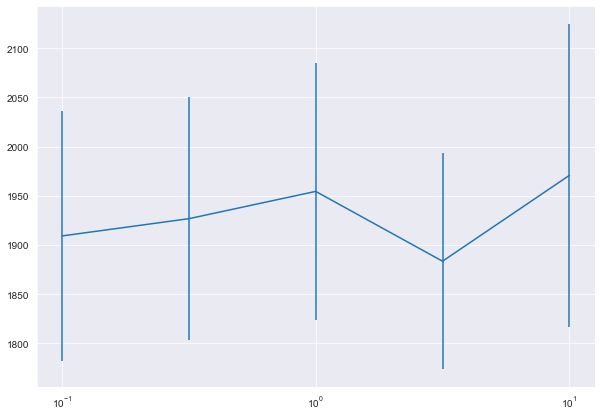

best_c=10.0, best_metric=1970.677423592782


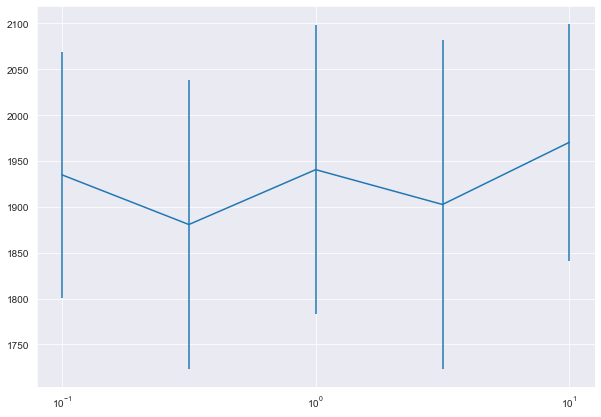

best_c=10.0, best_metric=1970.2572784717984


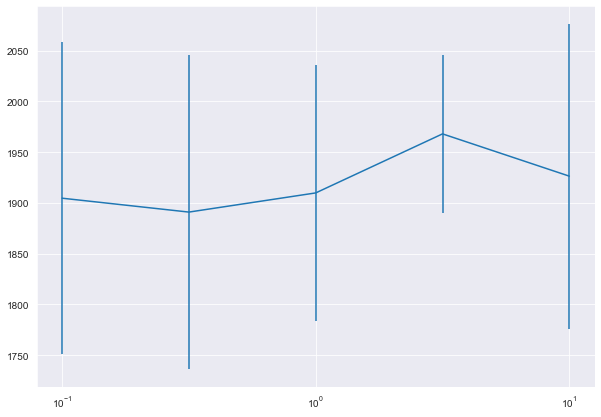

best_c=3.1622776601683795, best_metric=1968.0122605242686


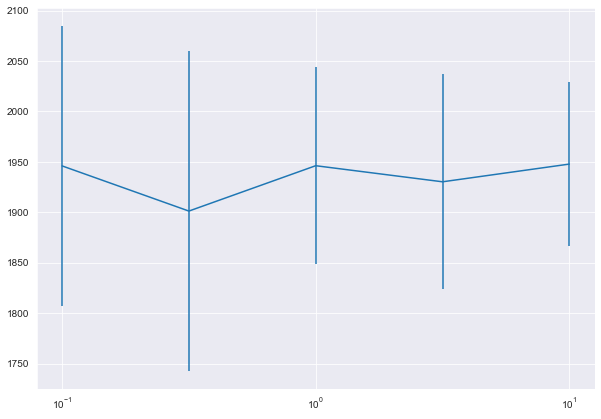

best_c=10.0, best_metric=1947.846108792092


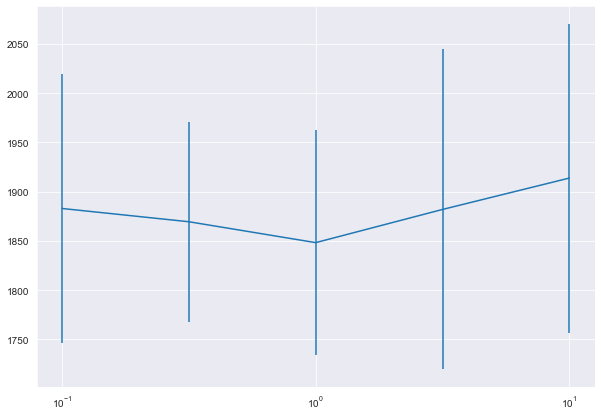

best_c=10.0, best_metric=1913.7308103143619


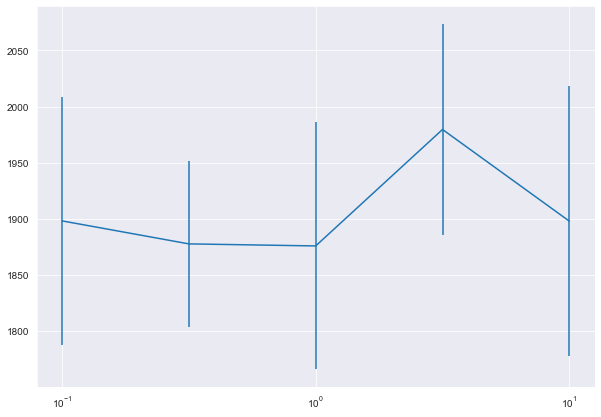

best_c=3.1622776601683795, best_metric=1979.5345701599035


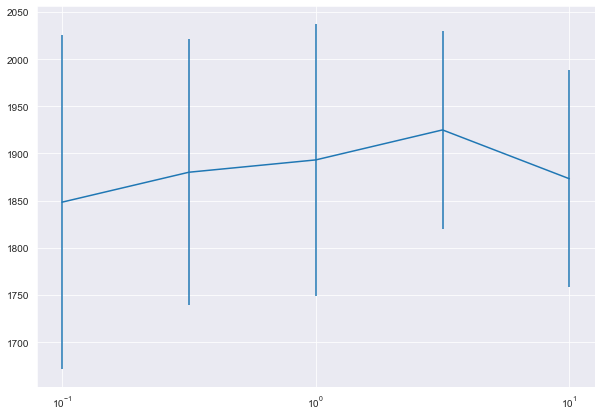

best_c=3.1622776601683795, best_metric=1924.9722027851778


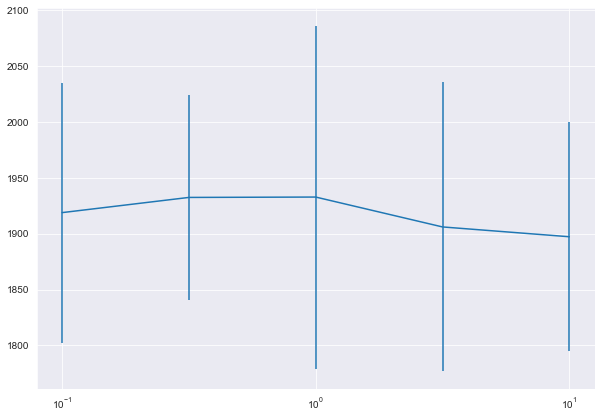

best_c=1.0, best_metric=1932.8368625089329


In [100]:
for i in range(10):
    C_search(False)

Очевидно, что графики будут разные, так как то, сколько потратит клиент это случайная величина, но по графику видим, что во многих случаях при $C=3$ прибыль наибольшая (для улучшения качества подбора С надо сделать больше фолдов)

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ **Мат. ожидание того, сколько денег можно получить с клиента равно 9.5, а денег звонящему мы заплатим все равно 1, поэтому важнее брать recall, так как лучше позвонить тому, кто не купит, чем не позвонить тому, с кого можно было бы заработать в среднем 8.5**



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [103]:
trans_X = column_transformer.fit_transform(X)

def bin_threshold_search(verbose=True):
    kf = KFold(n_splits=5, shuffle=True, random_state=500)
    best_threshold = 0
    best_metric = -1e6
    thresholds = []
    revs = []
    stds = []
    for threshold in tqdm(np.arange(0, 1, 0.01)):
        expenses, earnings = [], []
        for train_index, test_index in kf.split(X):
            model = LogisticRegression(max_iter=10000, C=3)
            model.fit(trans_X[train_index], y[train_index])
            fold_predicts = model.predict_proba(trans_X[test_index])[:, 1]
            fold_predicts = (fold_predicts >= threshold).astype(np.int32)
            expenses.append(fold_predicts.sum())
            payed_clients = y[test_index][fold_predicts == 1]
            earnings.append((np.random.uniform(20, size=payed_clients.shape[0]) * payed_clients).sum())
        earnings = np.array(earnings)
        expenses = np.array(expenses)
        revenue = earnings - expenses
        revenue_metric = revenue.mean()
        if revenue_metric > best_metric:
            best_metric = revenue_metric
            best_threshold = threshold
        if verbose:
            print(f"При threshold={threshold} в среднем выручка:", np.mean(revenue))
            print(f"При threshold={threshold} cтандартное отклонение выручки:", np.std(revenue))

        thresholds.append(threshold)
        revs.append(revenue_metric)
        stds.append(np.std(revenue))

    plt.figure(figsize=(15, 10))
    plt.errorbar(thresholds, revs, stds)
    plt.xscale('linear')
    plt.show()
    print(f"best_c={best_threshold}, best_metric={best_metric}")
    return best_threshold, best_metric

  0%|          | 0/100 [00:00<?, ?it/s]

При threshold=0.0 в среднем выручка: 1278.908368394526
При threshold=0.0 cтандартное отклонение выручки: 425.847965354636
При threshold=0.01 в среднем выручка: 1391.9429535771171
При threshold=0.01 cтандартное отклонение выручки: 197.71062300437202
При threshold=0.02 в среднем выручка: 1504.8590301649267
При threshold=0.02 cтандартное отклонение выручки: 400.8193191096664
При threshold=0.03 в среднем выручка: 2021.775851037355
При threshold=0.03 cтандартное отклонение выручки: 382.48992031489865
При threshold=0.04 в среднем выручка: 2795.3168848611863
При threshold=0.04 cтандартное отклонение выручки: 316.51023151883237
При threshold=0.05 в среднем выручка: 3574.4220898927424
При threshold=0.05 cтандартное отклонение выручки: 277.16694839340727
При threshold=0.06 в среднем выручка: 3920.5018201116304
При threshold=0.06 cтандартное отклонение выручки: 210.68775356008535
При threshold=0.07 в среднем выручка: 4205.58163404449
При threshold=0.07 cтандартное отклонение выручки: 190.86722813

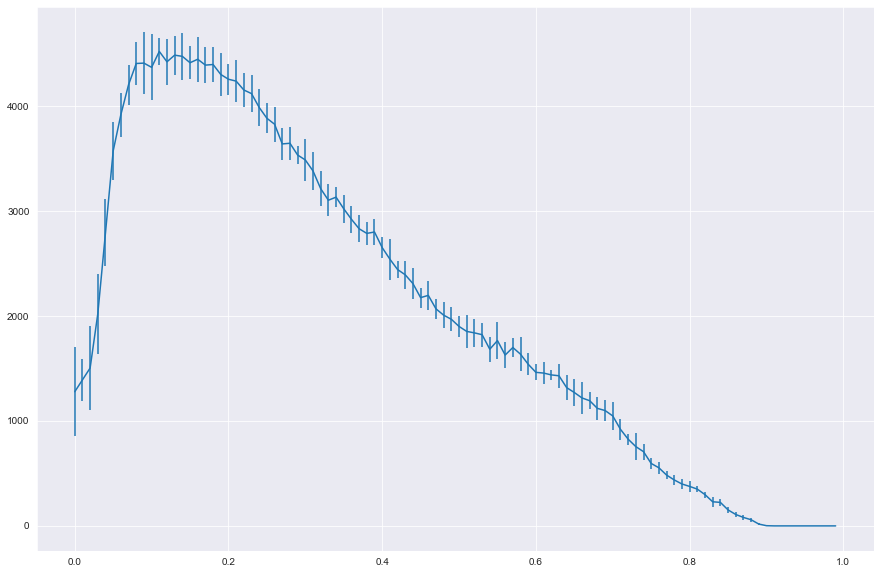

best_c=0.11, best_metric=4523.199003487219


(0.11, 4523.199003487219)

In [104]:
bin_threshold_search()

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

Видно, что прибыль до какого то момента растет, а зачем постепенно падает и сходится до нуля. Понятно, что обзванивать всех подряд не очень выгодно, но и не звонить никому еще более невыгодно, так как прибыль падает до нуля. Оптимальным порог находится в районе 0.11 для максимизации прибыли (так происходит потому что ожидаемая прибыль с человека в несколько раз превосходит затраты на оплату звонка

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [106]:
from sklearn.metrics import precision_score, recall_score


trans_X = column_transformer.fit_transform(X)
best_threshold = 0.11
precisions = []
recalls = []
for train_index, test_index in kf.split(trans_X):
    model = LogisticRegression(max_iter=10000, C=3)
    model.fit(trans_X[train_index], y[train_index])
    fold_predicts = model.predict_proba(trans_X[test_index])[:, 1]
    fold_predicts = (fold_predicts >= best_threshold).astype(np.int8)
    precisions.append(precision_score(y[test_index], fold_predicts))
    recalls.append(recall_score(y[test_index], fold_predicts))

print("Precision mean:", np.mean(precisions), "Precision std:", np.std(precisions))
print("Recall mean:", np.mean(recalls), "Recall std:", np.std(recalls))

Precision mean: 0.3371792635397102 Precision std: 0.01240570655042464
Recall mean: 0.641838422835898 Recall std: 0.020663619026138995


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [113]:
precisions = []
recalls = []
trans_X = column_transformer.fit_transform(X)

for threshold in np.arange(0, 1, 0.01):
    cur_precisions = []
    cur_recalls = []
    for train_index, test_index in kf.split(trans_X):
        model = LogisticRegression(max_iter=10000, C=3)
        model.fit(trans_X[train_index], y[train_index])
        fold_predicts = model.predict_proba(trans_X[test_index])[:, 1]
        fold_predicts = (fold_predicts >= threshold).astype(np.int8)
        cur_precisions.append(precision_score(y[test_index], fold_predicts))
        cur_recalls.append(recall_score(y[test_index], fold_predicts))

    precisions.append(np.mean(cur_precisions))
    recalls.append(np.mean(cur_recalls))
    print(f"for threshold={threshold} recall={recalls[-1]}")
    if recalls[-1] < 0.5:
        print("highest threshold for recall 0.5:", threshold - 0.1)
        break

for threshold=0.0 recall=1.0
for threshold=0.01 recall=1.0
for threshold=0.02 recall=0.9961633050757186
for threshold=0.03 recall=0.9722632022877656
for threshold=0.04 recall=0.9201322111479223
for threshold=0.05 recall=0.8589128867617845
for threshold=0.06 recall=0.795115952370296
for threshold=0.07 recall=0.7418287524356044
for threshold=0.08 recall=0.7044542759043468
for threshold=0.09 recall=0.6760141348802945
for threshold=0.1 recall=0.6590379954562826
for threshold=0.11 recall=0.641838422835898
for threshold=0.12 recall=0.6255071511454785
for threshold=0.13 recall=0.6135464319639089
for threshold=0.14 recall=0.607525735982177
for threshold=0.15 recall=0.6012789916795231
for threshold=0.16 recall=0.5969721991691541
for threshold=0.17 recall=0.590365985968709
for threshold=0.18 recall=0.5830999029446886
for threshold=0.19 recall=0.5776761228857529
for threshold=0.2 recall=0.565992781322557
for threshold=0.21 recall=0.5514001743298214
for threshold=0.22 recall=0.5392945867138541
for

PR_AUC: 0.41018041259068777


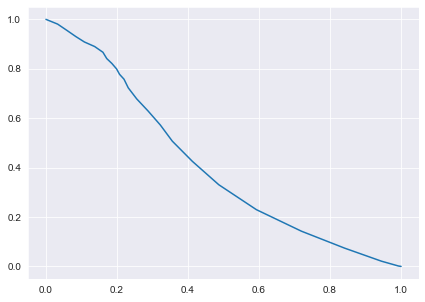

In [124]:
precisions = np.array(precisions)
recalls = np.array(recalls)
precisions = (precisions - np.min(precisions)) / (np.max(precisions) - np.min(precisions))
recalls = (recalls - np.min(recalls)) / (np.max(recalls) - np.min(recalls))
plt.figure(figsize=(7, 5))
plt.plot(recalls, precisions)
print("PR_AUC:", auc(recalls, precisions))

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ сырники со сметаной и черничным вареньем, а также зеленый чай